In [31]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [32]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [33]:
def fix_location(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_['location'].astype(str).str.contains('Kahraman Maras'), 'location'] = 'Kahramanmaras, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Şanliurfa'), 'location'] = 'Sanliurfa, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('İçel'), 'location'] = 'Mersin, Turkey'
    df_.loc[df_['location'].astype(str).str.contains('Afyon'), 'location'] = 'Afyonkarahisar, Turkey'
    df_['location'] = df_['location'].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_['location'] = df_['location'].apply(lambda x: x.upper().strip())
    df_['location'] = df_['location'].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_['location'] = df_['location'].apply(lambda x: city if city in x else x)
        df_['based_on_tr'] = df_['location'].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

In [34]:
skills_df = load_skills(config.skills_path, 60)
lang_df = load_languages(config.languages_path, 10)
edu_df = load_education(config.education_path, 21, 15)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')

#df['employee_total_last_exp_diff'] = df['employee_total_experience'] - df['employee_last_experience']

#df['nunique_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 320842


100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


(66274, 124)


,user_id,industry,location,moved_after_2019,based_on_tr,skill_Java,skill_JavaScript,skill_C#,skill_SQL,skill_Software Development,...,degree_Licentiate degree,degree_Bachelor of Applied Science,employee_total_experience,employee_last_experience,employee_lifetime,nunique_company,employee_avg_days_to_quit,company_id,company_avg_days_to_quit,nunique_company_by_industries
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1341.0,306.0,1035.0,3.0,447.000000,26.0,912.280537,3260.0
1,6950,Internet,ISTANBUL,0.0,1,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,2101.0,699.0,1402.0,4.0,525.250000,1337.0,393.769231,743.0
2,4880,Online Media,TURKEY,0.0,1,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1826.0,610.0,1216.0,4.0,456.500000,4366.0,NaN,32.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3409.0,1553.0,1856.0,1.0,3409.000000,26.0,912.280537,660.0
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3409.0,640.0,2769.0,3.0,1136.333333,1562.0,837.166667,424.0


In [35]:
#from kmodes.kmodes import KModes
#
#cluster = KModes(n_clusters=6, n_jobs=-1)
#
#cluster.fit_predict(df[[col for col in df.columns if 
#                        col.startswith('skill') or
#                        col.startswith('degree') or
#                        col.startswith('study') or
#                        col.startswith('language')]].fillna(0))



In [36]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 123)
test_set: (13255, 123)


In [37]:
# CatBoost Parameters
#params = {'one_hot_max_size': 179,
#          'depth': 12,
#          'boosting_type': 'Plain',
#          'bootstrap_type': 'MVS',
#          #'bagging_temperature': 0.2
#          }

params = {'one_hot_max_size': 156,
          'depth': 12,
          'boosting_type': 'Plain',
          'bootstrap_type': 'MVS'}

params["iterations"] = 4000
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params['verbose'] = False

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

#kf = KFold(n_splits=config.n_folds, shuffle=config.shuffle, random_state=config.seed)
kf = KFold(n_splits=config.n_folds)

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6538636	test: 0.6445626	best: 0.6445626 (0)	total: 219ms	remaining: 14m 34s
200:	learn: 0.8576343	test: 0.7511599	best: 0.7516125 (196)	total: 31.2s	remaining: 9m 49s
400:	learn: 0.9184283	test: 0.7643997	best: 0.7647392 (399)	total: 1m 3s	remaining: 9m 25s
600:	learn: 0.9455208	test: 0.7699446	best: 0.7701709 (571)	total: 1m 35s	remaining: 9m 1s
800:	learn: 0.9622697	test: 0.7734525	best: 0.7736789 (787)	total: 2m 6s	remaining: 8m 27s
1000:	learn: 0.9729754	test: 0.7753763	best: 0.7771868 (889)	total: 2m 38s	remaining: 7m 53s
1200:	learn: 0.9801503	test: 0.7774131	best: 0.7777526 (1109)	total: 3m 9s	remaining: 7m 21s
1400:	learn: 0.9848807	test: 0.7779790	best: 0.7789974 (1339)	total: 3m 40s	remaining: 6m 49s
1600:	learn: 0.9883210	test: 0.7795632	best: 0.7802422 (1499)	total: 4m 12s	remaining: 6m 18s
1800:	learn: 0.9906297	test: 0.7793369	best: 0.7812606 (1781)	t

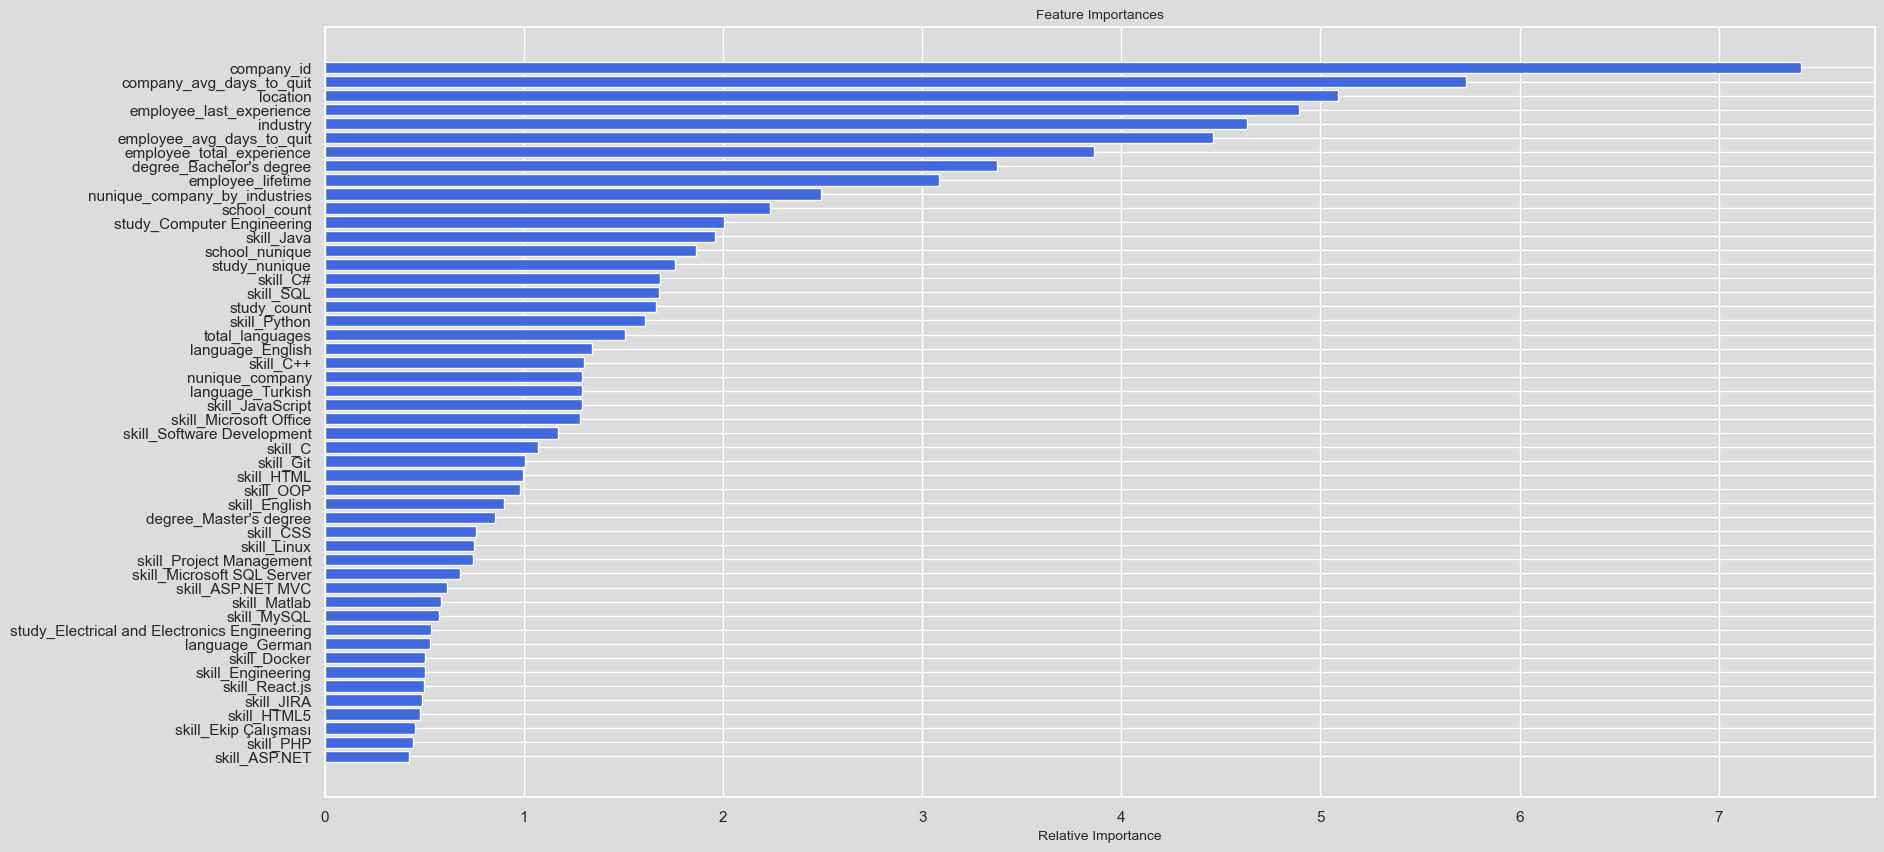

fold accuracy: 0.7814869299536041
-----------------------------------| Fold 2 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6500158	test: 0.6389046	best: 0.6389046 (0)	total: 241ms	remaining: 16m 4s
200:	learn: 0.8583133	test: 0.7564784	best: 0.7574969 (190)	total: 33s	remaining: 10m 24s
400:	learn: 0.9146938	test: 0.7697182	best: 0.7703972 (397)	total: 1m 4s	remaining: 9m 37s
600:	learn: 0.9453624	test: 0.7735657	best: 0.7749236 (579)	total: 1m 35s	remaining: 9m
800:	learn: 0.9643067	test: 0.7777526	best: 0.7778658 (669)	total: 2m 6s	remaining: 8m 25s
1000:	learn: 0.9744240	test: 0.7780921	best: 0.7795632 (959)	total: 2m 37s	remaining: 7m 52s
1200:	learn: 0.9813725	test: 0.7829580	best: 0.7830712 (1184)	total: 3m 8s	remaining: 7m 19s
1400:	learn: 0.9860577	test: 0.7812606	best: 0.7830712 (1184)	total: 3m 39s	remaining: 6m 47s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.783071178
bestIteration = 1184

Shrink model to first 1185 

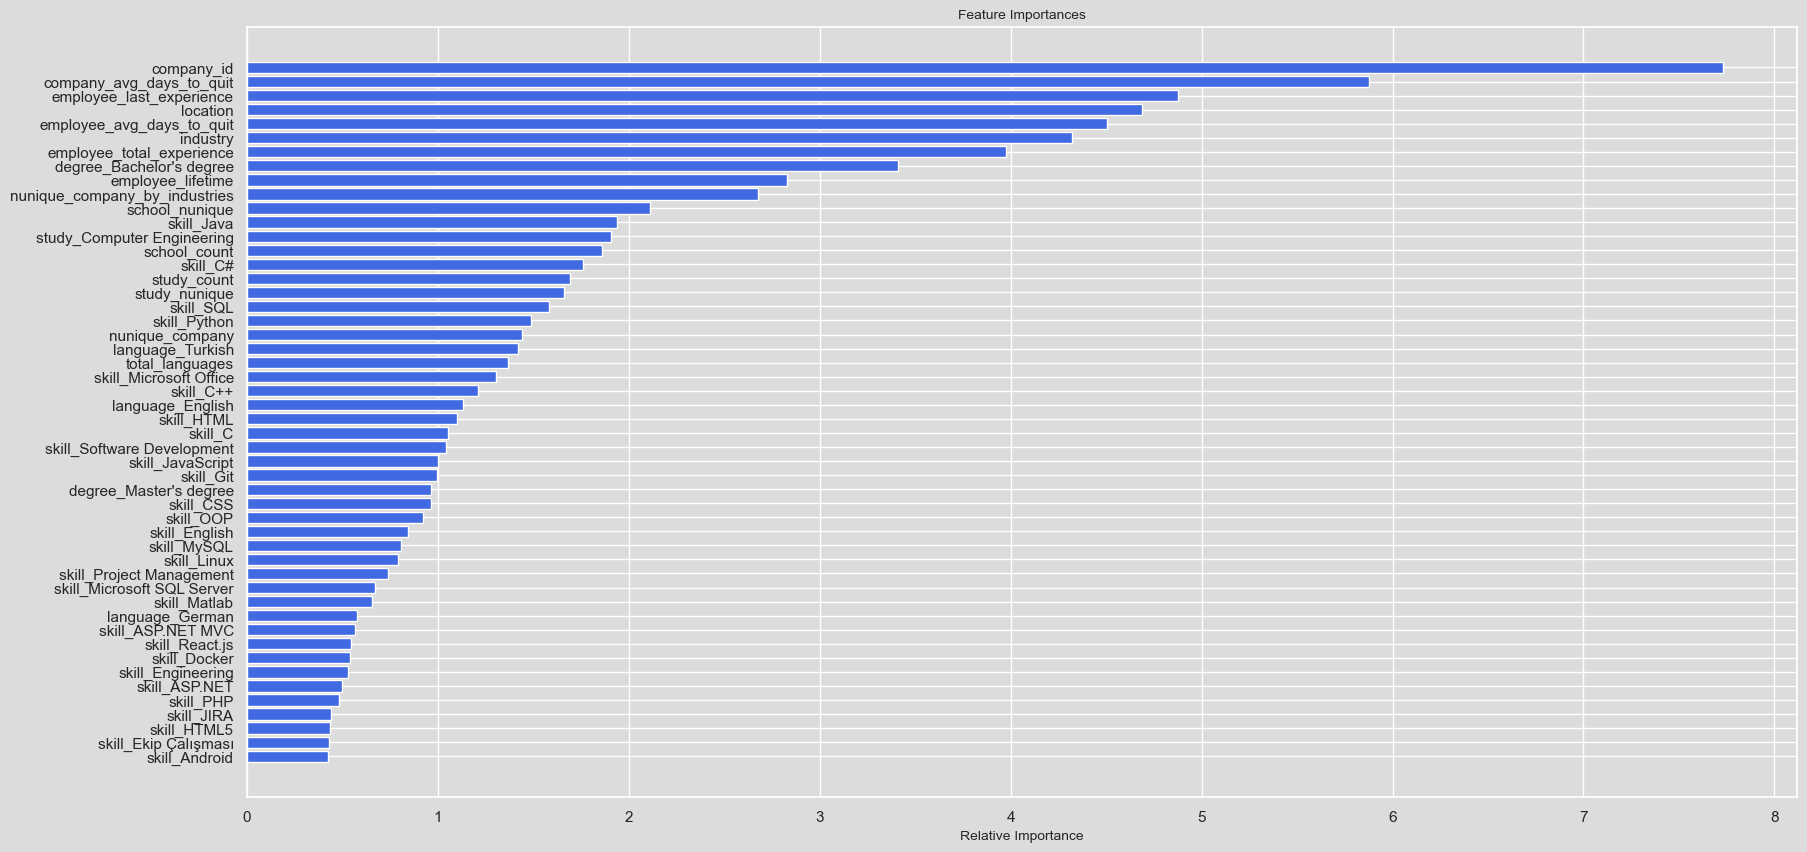

fold accuracy: 0.7830711780015842
-----------------------------------| Fold 3 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6398760	test: 0.6277017	best: 0.6277017 (0)	total: 191ms	remaining: 12m 43s
200:	learn: 0.8581323	test: 0.7529705	best: 0.7529705 (200)	total: 30.7s	remaining: 9m 40s
400:	learn: 0.9119777	test: 0.7682471	best: 0.7686998 (393)	total: 1m 1s	remaining: 9m 12s
600:	learn: 0.9426690	test: 0.7680208	best: 0.7710762 (456)	total: 1m 33s	remaining: 8m 49s
800:	learn: 0.9610022	test: 0.7731130	best: 0.7737920 (799)	total: 2m 4s	remaining: 8m 18s
1000:	learn: 0.9727038	test: 0.7773000	best: 0.7775263 (996)	total: 2m 36s	remaining: 7m 47s
1200:	learn: 0.9804219	test: 0.7794500	best: 0.7812606 (1161)	total: 3m 7s	remaining: 7m 15s
1400:	learn: 0.9853787	test: 0.7784316	best: 0.7812606 (1161)	total: 3m 40s	remaining: 6m 48s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7812606088
bestIteration = 1161

Shrink model to firs

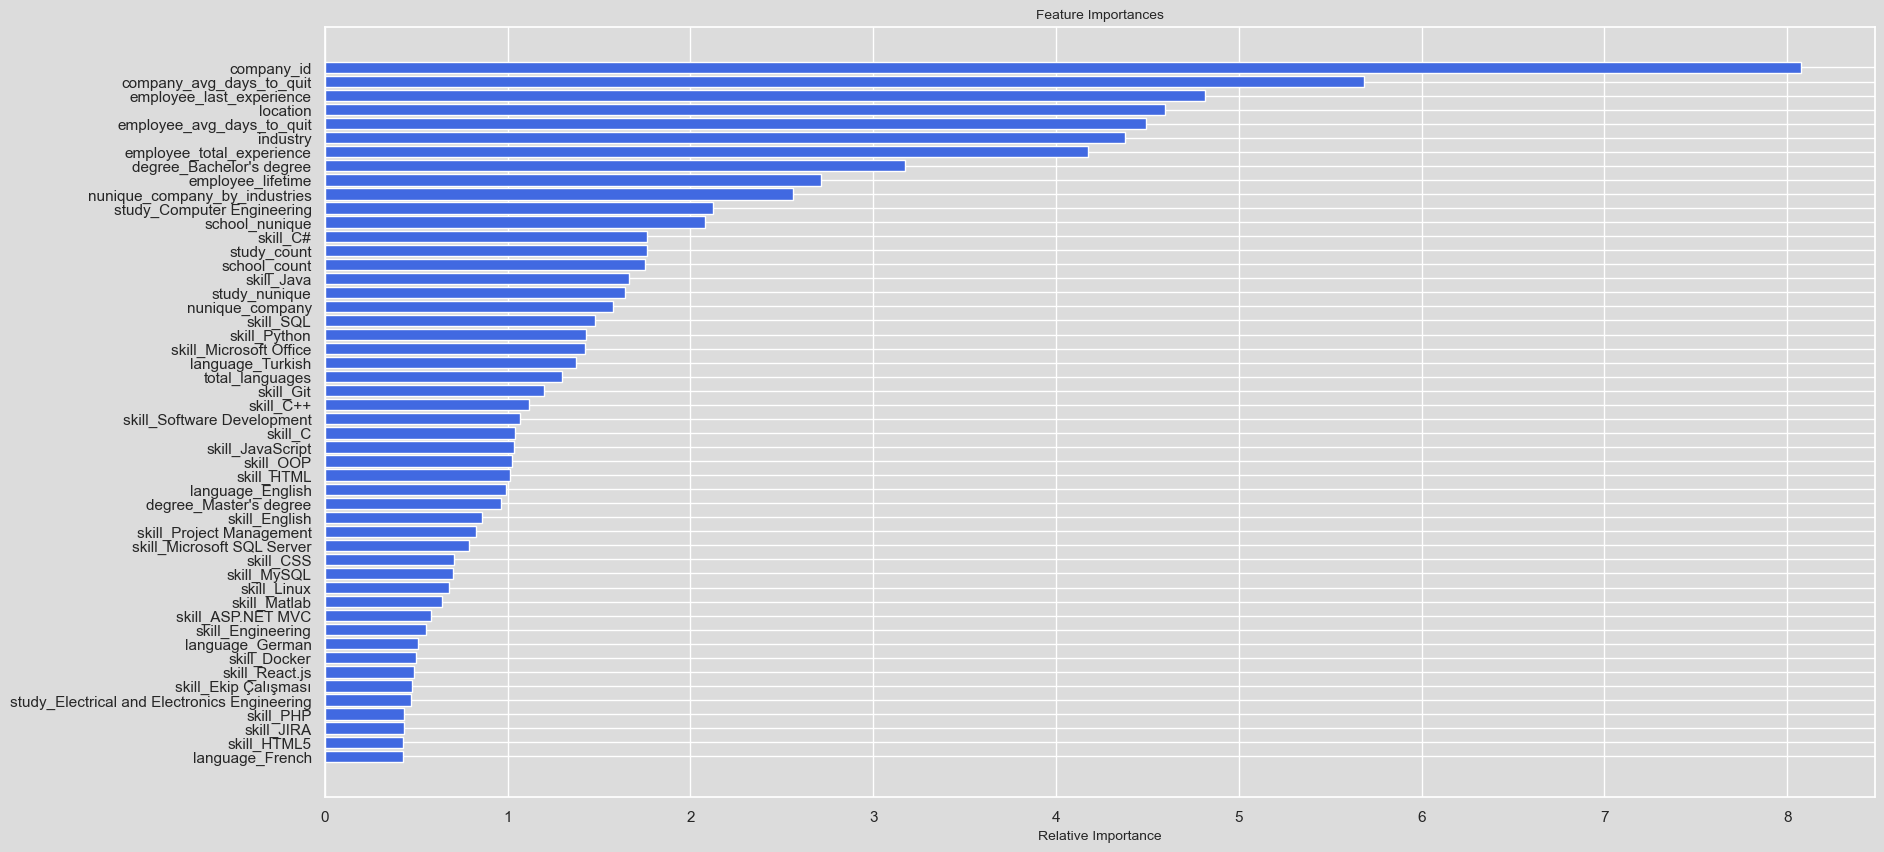

fold accuracy: 0.7812606088038927
-----------------------------------| Fold 4 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6449087	test: 0.6282254	best: 0.6282254 (0)	total: 220ms	remaining: 14m 38s
200:	learn: 0.8592445	test: 0.7469443	best: 0.7488683 (194)	total: 31s	remaining: 9m 45s
400:	learn: 0.9174117	test: 0.7668628	best: 0.7668628 (400)	total: 1m 1s	remaining: 9m 15s
600:	learn: 0.9463142	test: 0.7705976	best: 0.7708239 (598)	total: 1m 34s	remaining: 8m 53s
800:	learn: 0.9617726	test: 0.7728610	best: 0.7738796 (748)	total: 2m 6s	remaining: 8m 24s
1000:	learn: 0.9731571	test: 0.7735401	best: 0.7780670 (892)	total: 2m 37s	remaining: 7m 51s
1200:	learn: 0.9808976	test: 0.7732005	best: 0.7780670 (892)	total: 3m 8s	remaining: 7m 18s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7780669986
bestIteration = 892

Shrink model to first 893 iterations.


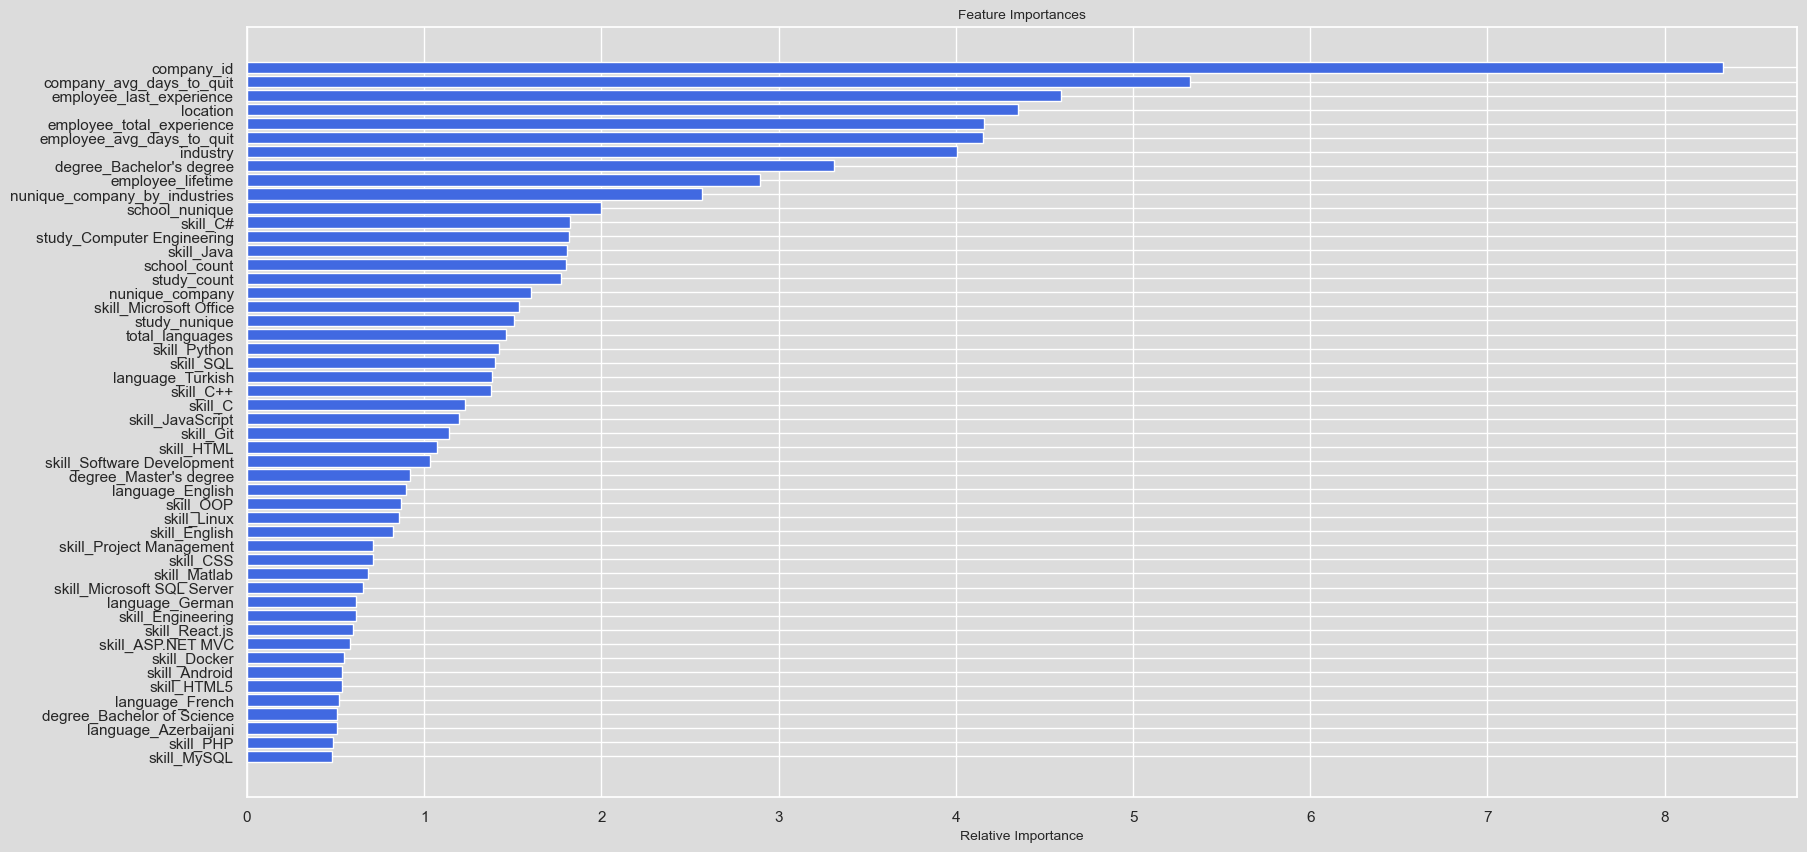

fold accuracy: 0.7780669986419194
-----------------------------------| Fold 5 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6397031	test: 0.6284518	best: 0.6284518 (0)	total: 241ms	remaining: 16m 2s
200:	learn: 0.8620963	test: 0.7601856	best: 0.7601856 (200)	total: 38.2s	remaining: 12m 2s
400:	learn: 0.9184754	test: 0.7684473	best: 0.7695790 (388)	total: 1m 17s	remaining: 11m 31s
600:	learn: 0.9482380	test: 0.7760299	best: 0.7763694 (596)	total: 1m 56s	remaining: 10m 56s
800:	learn: 0.9659145	test: 0.7784065	best: 0.7793119 (762)	total: 2m 35s	remaining: 10m 20s
1000:	learn: 0.9758957	test: 0.7805568	best: 0.7822544 (882)	total: 3m 15s	remaining: 9m 44s
1200:	learn: 0.9833420	test: 0.7797646	best: 0.7822544 (882)	total: 3m 54s	remaining: 9m 6s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.7822544138
bestIteration = 882

Shrink model to first 883 iterations.


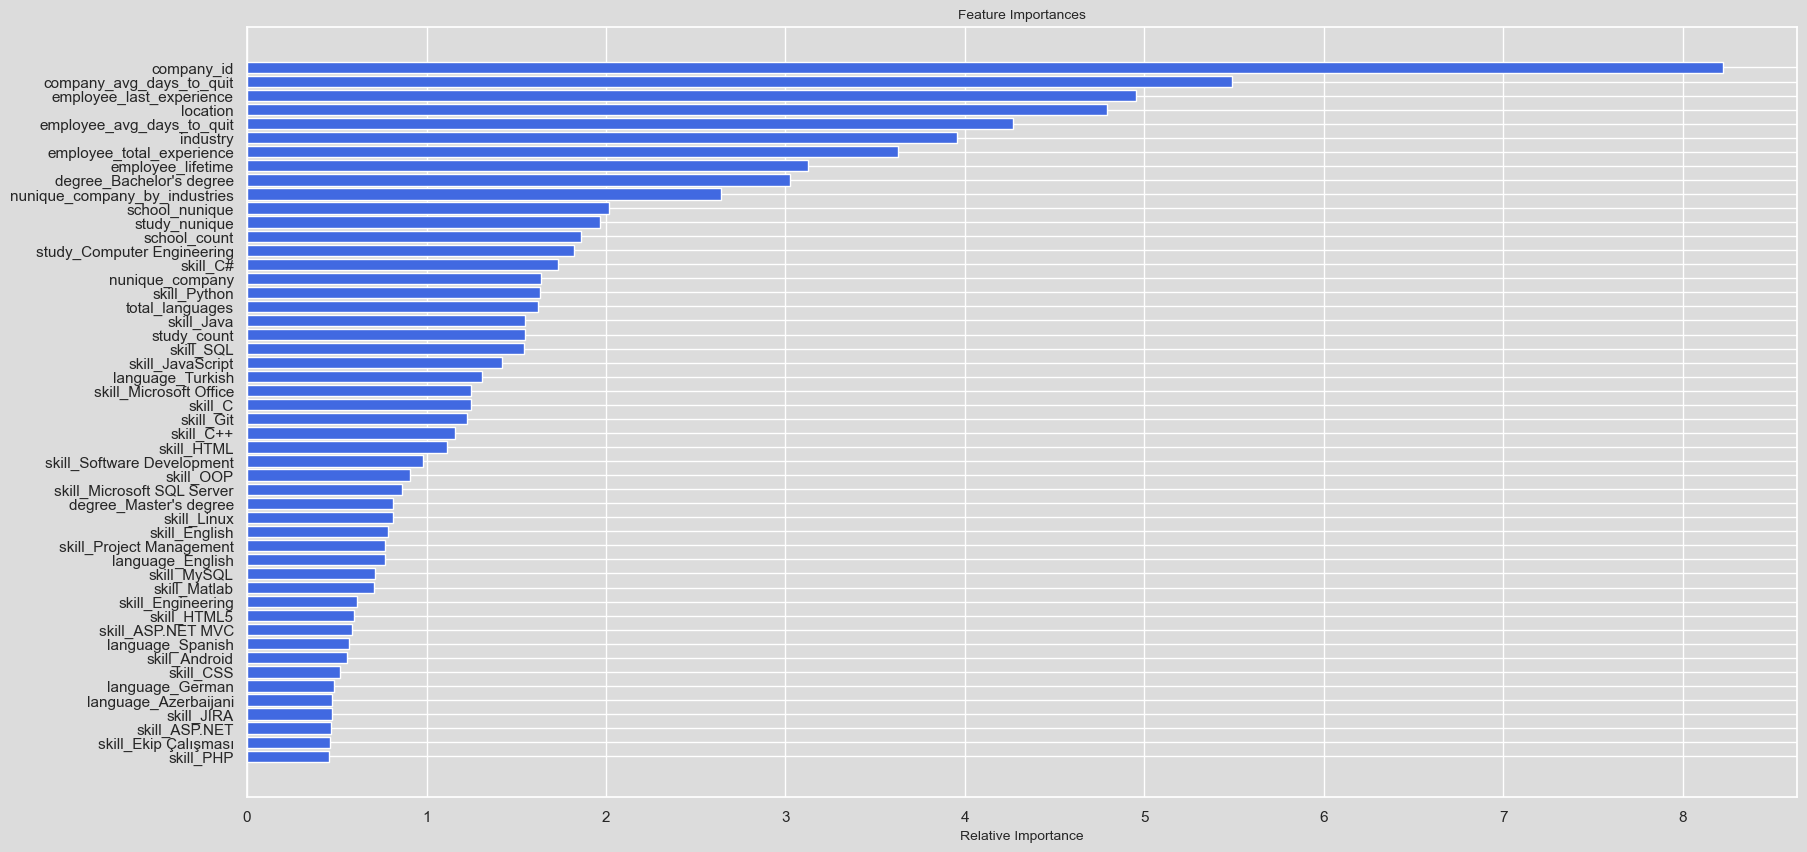

fold accuracy: 0.7822544137618832
-----------------------------------| Fold 6 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6441844	test: 0.6226799	best: 0.6226799 (0)	total: 208ms	remaining: 13m 49s
200:	learn: 0.8615305	test: 0.7458126	best: 0.7460389 (199)	total: 30.2s	remaining: 9m 31s
400:	learn: 0.9099880	test: 0.7597329	best: 0.7601856 (382)	total: 1m 2s	remaining: 9m 20s
600:	learn: 0.9411086	test: 0.7681077	best: 0.7681077 (598)	total: 1m 32s	remaining: 8m 45s
800:	learn: 0.9596451	test: 0.7717293	best: 0.7726347 (792)	total: 2m 3s	remaining: 8m 14s
1000:	learn: 0.9727271	test: 0.7752377	best: 0.7752377 (1000)	total: 2m 35s	remaining: 7m 45s
1200:	learn: 0.9804450	test: 0.7753508	best: 0.7768221 (1159)	total: 3m 6s	remaining: 7m 14s
1400:	learn: 0.9849942	test: 0.7771616	best: 0.7776143 (1381)	total: 3m 37s	remaining: 6m 42s
1600:	learn: 0.9882308	test: 0.7787460	best: 0.7808963 (1521)	total: 4m 7s	remaining: 6m 11s
1800:	learn: 0.9907430	test:

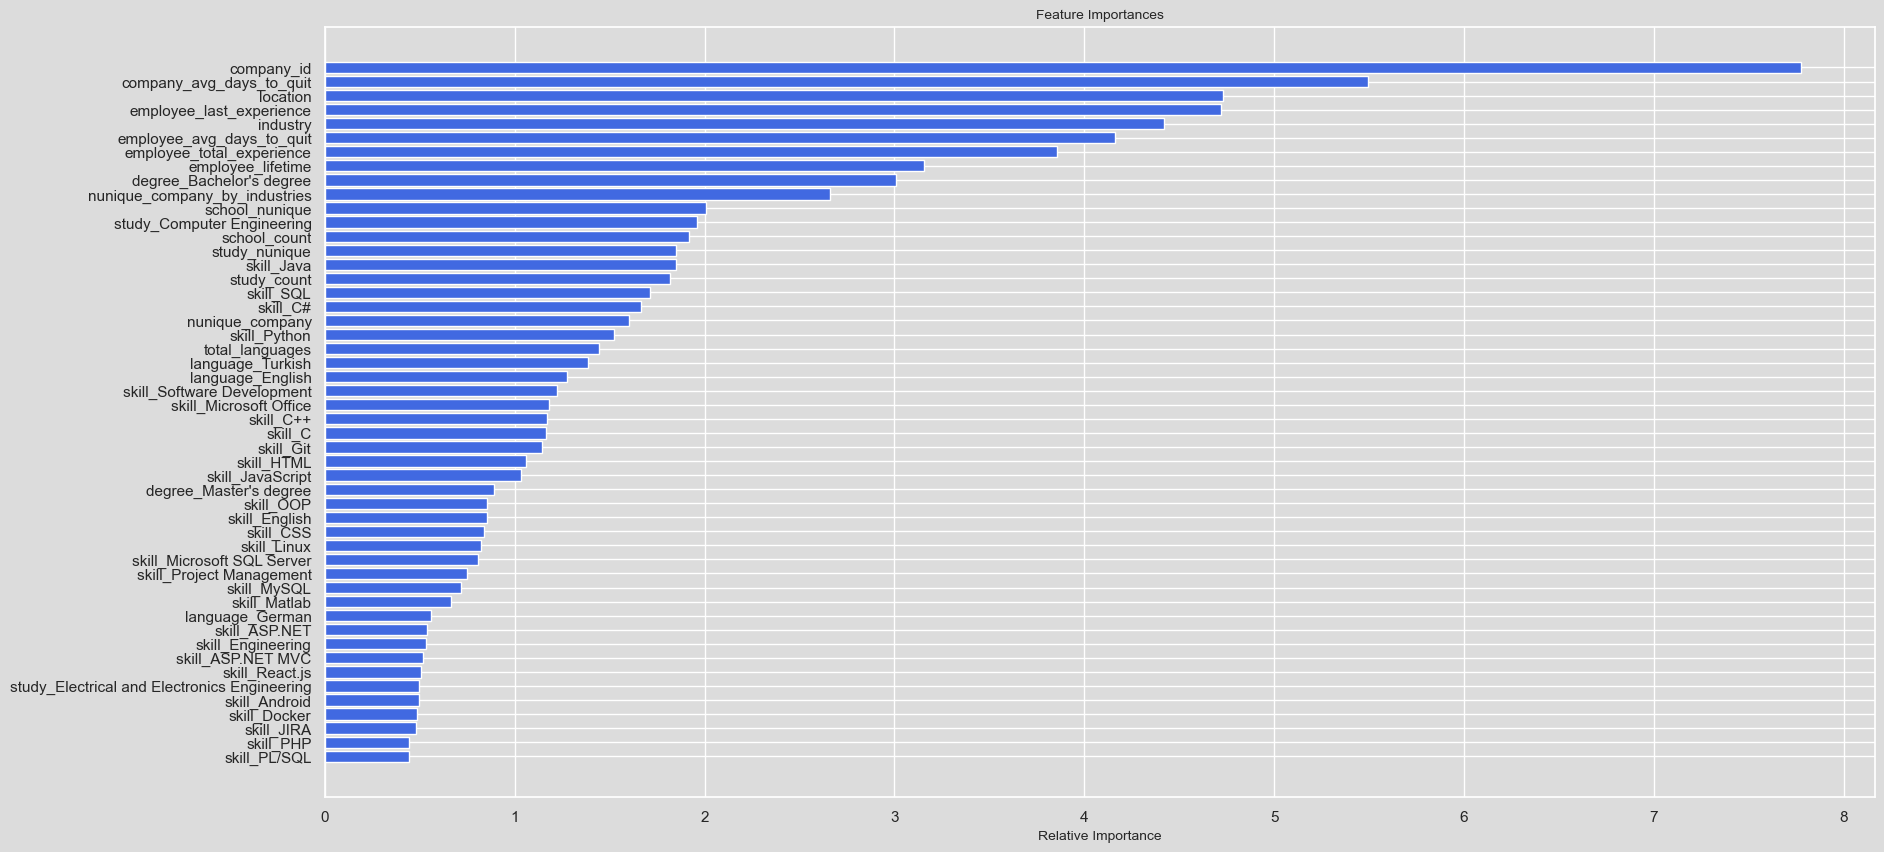

fold accuracy: 0.7808963331824355
accuracy: 0.7811727871140535


In [38]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])

for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')

accuracy: 0.7788151417416398

accuracy: 0.7780229728965088 (submission sonrası)

In [39]:
sub[target] = np.where(y_pred >= 0.5, 1, 0).tolist()

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0


In [ ]:
sub.to_csv(f'../submissions/submission_{round(val_score, 6)}.csv', index = False)